# Make bound and free states from the prepped inputs

### Imports

In [1]:
%load_ext lab_black
# Python standard library
from glob import glob
import os
import socket
import sys

# 3rd party library imports
import dask
import matplotlib.pyplot as plt
import pandas as pd
import pyrosetta
import numpy as np
import scipy
import seaborn as sns
from tqdm.auto import tqdm  # jupyter compatible progress bar

tqdm.pandas()  # link tqdm to pandas
# Notebook magic
# save plots in the notebook
%matplotlib inline
# reloads modules automatically before executing cells
%load_ext autoreload
%autoreload 2
print(f"running in directory: {os.getcwd()}")  # where are we?
print(f"running on node: {socket.gethostname()}")  # what node are we on?

running in directory: /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties
running on node: dig39


### Set working directory to the root of the crispy_shifty repo
TODO set to projects dir

In [2]:
os.chdir("/home/pleung/projects/crispy_shifty")
# os.chdir("/projects/crispy_shifty")

### One-state design the helix-bound states
TODO

In [3]:
from crispy_shifty.utils.io import gen_array_tasks

simulation_name = "00_design_bound_states"
design_list_file = os.path.join(
    os.getcwd(), "scaffolds/02_make_bound_states/bound_states.list"
)
output_path = os.path.join(os.getcwd(), f"projects/crispy_shifties/{simulation_name}")
options = " ".join(
    [
        "out:level 200",
        # "indexed_structure_store:fragment_store /home/bcov/sc/scaffold_comparison/data/ss_grouped_vall_all.h5",
    ]
)

gen_array_tasks(
    distribute_func="crispy_shifty.protocols.design.one_state_design_bound_state",
    design_list_file=design_list_file,
    output_path=output_path,
    queue="medium",
    memory="4G",
    nstruct=1,
    nstruct_per_task=1,
    options=options,
    simulation_name=simulation_name,
)

https://docs.anaconda.com/anaconda/install

Run the following command with your desired environment active:
sbatch -a 1-$(cat /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/00_design_bound_states/tasks.cmds | wc -l) /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/00_design_bound_states/run.sh


/projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [4]:
!sbatch -a 1-$(cat /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/00_design_bound_states/tasks.cmds | wc -l) /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/00_design_bound_states/run.sh

Submitted batch job 66953614


### Collect scorefiles of designed bound states and concatenate
TODO change to projects dir

In [3]:
sys.path.insert(0, "~/projects/crispy_shifty")  # TODO
from crispy_shifty.utils.io import collect_score_file

simulation_name = "00_design_bound_states"
output_path = os.path.join(os.getcwd(), f"projects/crispy_shifties/{simulation_name}")

if not os.path.exists(os.path.join(output_path, "scores.json")):
    collect_score_file(output_path, "scores")

/projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


### Load resulting concatenated scorefile
TODO change to projects dir

In [8]:
sys.path.insert(0, "~/projects/crispy_shifty")  # TODO
from crispy_shifty.utils.io import parse_scorefile_linear

output_path = os.path.join(os.getcwd(), f"projects/crispy_shifties/{simulation_name}")

scores_df = parse_scorefile_linear(os.path.join(output_path, "scores.json"))

SyntaxError: invalid syntax (io.py, line 474)

# Setup for plotting

In [5]:
sns.set(
    context="talk",
    font_scale=1,  # make the font larger; default is pretty small
    style="ticks",  # make the background white with black lines
    palette="colorblind",  # a color palette that is colorblind friendly!
)

### Data exploration

In [6]:
scores_df.columns

Index(['bb_clash', 'best_average_DAN_plddts', 'best_average_plddts',
       'best_model', 'best_ptm', 'best_rmsd_to_input', 'buns_parent',
       'cms_AcB', 'cms_AnAc', 'cms_AnAcB', 'cms_AnB', 'docked_helix',
       'dslf_fa13', 'exposed_hydrophobics_parent', 'fa_atr', 'fa_dun',
       'fa_dun_dev', 'fa_dun_rot', 'fa_dun_semi', 'fa_elec',
       'fa_intra_atr_xover4', 'fa_intra_elec', 'fa_intra_rep',
       'fa_intra_rep_xover4', 'fa_intra_sol_xover4', 'fa_rep', 'fa_sol',
       'geometry_parent', 'hbond_bb_sc', 'hbond_lr_bb', 'hbond_sc',
       'hbond_sr_bb', 'holes_all_parent', 'holes_core_parent', 'hxl_tors',
       'lk_ball', 'lk_ball_bridge', 'lk_ball_bridge_uncpl', 'lk_ball_iso',
       'lk_ball_wtd', 'loop_dist', 'metadata', 'mismatch_probability_parent',
       'omega', 'p_aa_pp', 'packstat_parent', 'parent', 'parent_length', 'pdb',
       'pivot_helix', 'pre_break_helix', 'pro_close', 'rama_prepro', 'ref',
       'res_type_constraint', 'sap_parent', 'sc_AcB', 'sc_AnAc', 'sc_An

In [12]:
scores_df["time"] = scores_df.metadata.astype(float) / 60
scores_df["trimmed_length"] = scores_df.trimmed_length.astype(int)

2it [00:00, 30.65it/s]


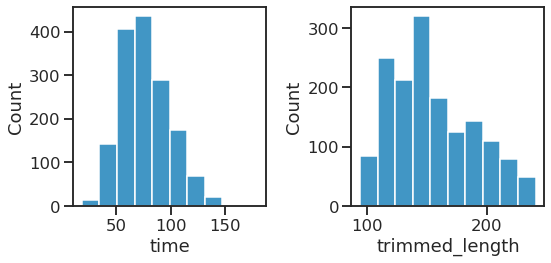

In [13]:
from crispy_shifty.plotting.utils import histplot_df, pairplot_df

histplot_df(df=scores_df, bins=10, cols=["time", "trimmed_length"])

<Figure size 576x576 with 0 Axes>

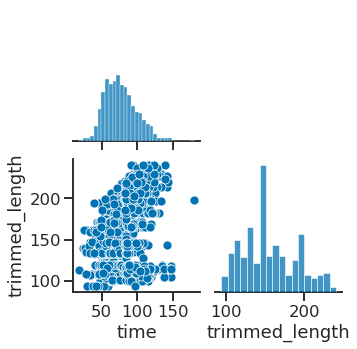

In [14]:
pairplot_df(df=scores_df, cols=["time", "trimmed_length"])

### TODO Save a list of outputs

In [6]:
# with open(
#     os.path.join(os.getcwd(), "scaffolds/02_make_bound_states/bound_states.list"), "w"
# ) as f:
#     for path in tqdm(bound_scores_df.index):
#         print(path, file=f)
# with open(
#     os.path.join(os.getcwd(), "scaffolds/02_make_free_states/free_states.list"), "w"
# ) as f:
#     for path in tqdm(free_scores_df.index):
#         print(path, file=f)

### Prototyping blocks
`"-indexed_structure_store:fragment_store": "/home/bcov/sc/scaffold_comparison/data/ss_grouped_vall_all.h5",` isn't needed.  
`-precompute_ig true \-precompute_ig true \`
`-indexed_structure_store:fragment_store /net/databases/VALL_clustered/connect_chains/ss_grouped_vall_helix_shortLoop.h5 \`

In [3]:
%%time 
import pyrosetta

pyrosetta.init(
    "-corrections::beta_nov16"
)


sys.path.insert(0, "~/projects/crispy_shifty/") # TODO projects
from crispy_shifty.protocols.design import one_state_design_bound_state

t = one_state_design_bound_state(
        None,
        **{
            'pdb_path': '/mnt/home/pleung/projects/crispy_shifty/scaffolds/02_make_bound_states/decoys/0000/notebooks_02_make_bound_states_6f2b82a6c1404a7389d1fe5797fb9176.pdb.bz2',
        }
)

PyRosetta-4 2021 [Rosetta PyRosetta4.conda.linux.cxx11thread.serialization.CentOS.python38.Release 2021.44+release.de9edbfaf502e0b00debd50df9e9c36eb454838a 2021-11-02T20:42:19] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
core.init: Checking for fconfig files in pwd and ./rosetta/flags
core.init: Rosetta version: PyRosetta4.conda.linux.cxx11thread.serialization.CentOS.python38.Release r301 2021.44+release.de9edbf de9edbfaf502e0b00debd50df9e9c36eb454838a http://www.pyrosetta.org 2021-11-02T20:42:19
core.init: command: PyRosetta -corrections::beta_nov16 -database /projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/pyrosetta/database
basic.random.init_random_generator: 'RNG device' seed mode, using '/dev/urandom', seed=1826118104 seed_offset=0 real_seed=1826118104 thread_index=0
basic.random.init_random_generator: RandomGenerator:init: Normal mode, seed=1826118104 RG_type=mt19937

In [ ]:
for i, tppose in enumerate(t):
    tppose.pose.dump_pdb(f"{i}.pdb")

0.00 min: Generated interface selector
core.select.residue_selector.LayerSelector: Setting LayerSelector to use sidechain neighbors to determine burial.
core.select.residue_selector.LayerSelector: Set cutoffs for core and surface to 5.2 and 2, respectively, in LayerSelector.
core.select.residue_selector.LayerSelector: Setting core=true boundary=false surface=false in LayerSelector.
core.select.residue_selector.LayerSelector: Setting LayerSelector to use sidechain neighbors to determine burial.
core.select.residue_selector.LayerSelector: Setting LayerSelector to use sidechain neighbors to determine burial.
core.select.residue_selector.LayerSelector: Set cutoffs for core and surface to 5.2 and 2, respectively, in LayerSelector.
core.select.residue_selector.LayerSelector: Setting core=false boundary=true surface=false in LayerSelector.
core.select.residue_selector.LayerSelector: Setting LayerSelector to use sidechain neighbors to determine burial.
core.select.residue_selector.LayerSelecto

/projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


core.conformation.Conformation: [ WARNING ] missing heavyatom:  OXT on residue LEU:CtermProteinFull 77
core.conformation.Conformation: [ WARNING ] missing heavyatom:  OXT on residue LEU:CtermProteinFull 150
select design_sel, (chain A and resid 61,62,65,66,68,69,72,73) or (chain B and resid 80,81,83,84,85,87,88,90,91,94,95,97,100,103,107) or (chain C and resid 133,136,137,140,141,143,144,148)
{'bb_clash': '39.48820877075195', 'best_average_DAN_plddts': '0.94140625', 'best_average_plddts': '95.5781062937', 'best_model': '2', 'best_ptm': '0.8570135160000001', 'best_rmsd_to_input': '1.1307091845', 'buns_parent': '0.0', 'docked_helix': '3', 'dslf_fa13': '0.0', 'exposed_hydrophobics_parent': '742.7557373046875', 'fa_atr': '-952.4328631824205', 'fa_dun': '277.6150651452243', 'fa_dun_dev': '22.566758220895796', 'fa_dun_rot': '125.6771810081174', 'fa_dun_semi': '135.28502680613883', 'fa_elec': '-282.2033608643161', 'fa_intra_atr_xover4': '-61.02398186984928', 'fa_intra_elec': '-15.204921676787

test crispy shifty array task utils

In [7]:
from crispy_shifty.utils.io import gen_array_tasks

simulation_name = "test"
design_list_file = os.path.join(
    os.getcwd(), "scaffolds/02_make_bound_states/bound_states.list"
)
output_path = os.path.join(os.getcwd(), f"projects/crispy_shifties/{simulation_name}")
options = " ".join(
    [
        "out:level 200",
        # "indexed_structure_store:fragment_store /home/bcov/sc/scaffold_comparison/data/ss_grouped_vall_all.h5",
    ]
)

gen_array_tasks(
    distribute_func="crispy_shifty.utils.io.test_func",
    design_list_file=design_list_file,
    output_path=output_path,
    queue="medium",
    memory="4G",
    nstruct=1,
    nstruct_per_task=1,
    options=options,
    simulation_name=simulation_name,
)

Run the following command with your desired environment active:
sbatch -a 1-$(cat /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/test/tasks.cmds | wc -l) /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/test/run.sh


In [8]:
!sbatch -a 1-$(cat /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/test/tasks.cmds | wc -l) /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/test/run.sh

Submitted batch job 806707
